# Polarized observations

This tutorial covers working with polarized instrument and maps, and recovering polarized maps from observations.

We start with a normal instrument, and create two orthogonally polarized copies of each detector by setting ``polarized: True`` in the ``Array`` config:

In [1]:
import maria
from maria.instrument import Band

f090 = Band(
    center=90e9,  # in Hz
    width=20e9,  # in Hz
    NET_RJ=40e-6,  # in K sqrt(s)
    knee=1e0,    # in Hz
    gain_error=5e-2)

f150 = Band(
    center=150e9, 
    width=30e9, 
    NET_RJ=60e-6, 
    knee=1e0, 
    gain_error=5e-2)

array = {"field_of_view": 0.5, 
         "shape": "circle", 
         "beam_spacing": 1.5,
         "primary_size": 10, 
         "polarized": True,
         "bands": [f090, f150]}

instrument = maria.get_instrument(array=array)

print(instrument.arrays)

          n     FOV baseline        bands polarized
array1  652  0.478°      0 m  [f090,f150]      True


We can see the resulting polarization footprint in the instrument plot:

Instrument(1 array)
├ arrays:
│            n     FOV baseline        bands polarized
│  array1  652  0.478°      0 m  [f090,f150]      True
│ 
└ bands:
      name   center   width    η         NEP      NET_RJ         NET_CMB     FWHM
   0  f090   90 GHz  20 GHz  0.5  5.445 aW√s  40 uK_RJ√s  49.13 uK_CMB√s   1.458’
   1  f150  150 GHz  30 GHz  0.5  12.25 aW√s  60 uK_RJ√s    104 uK_CMB√s  0.8748’


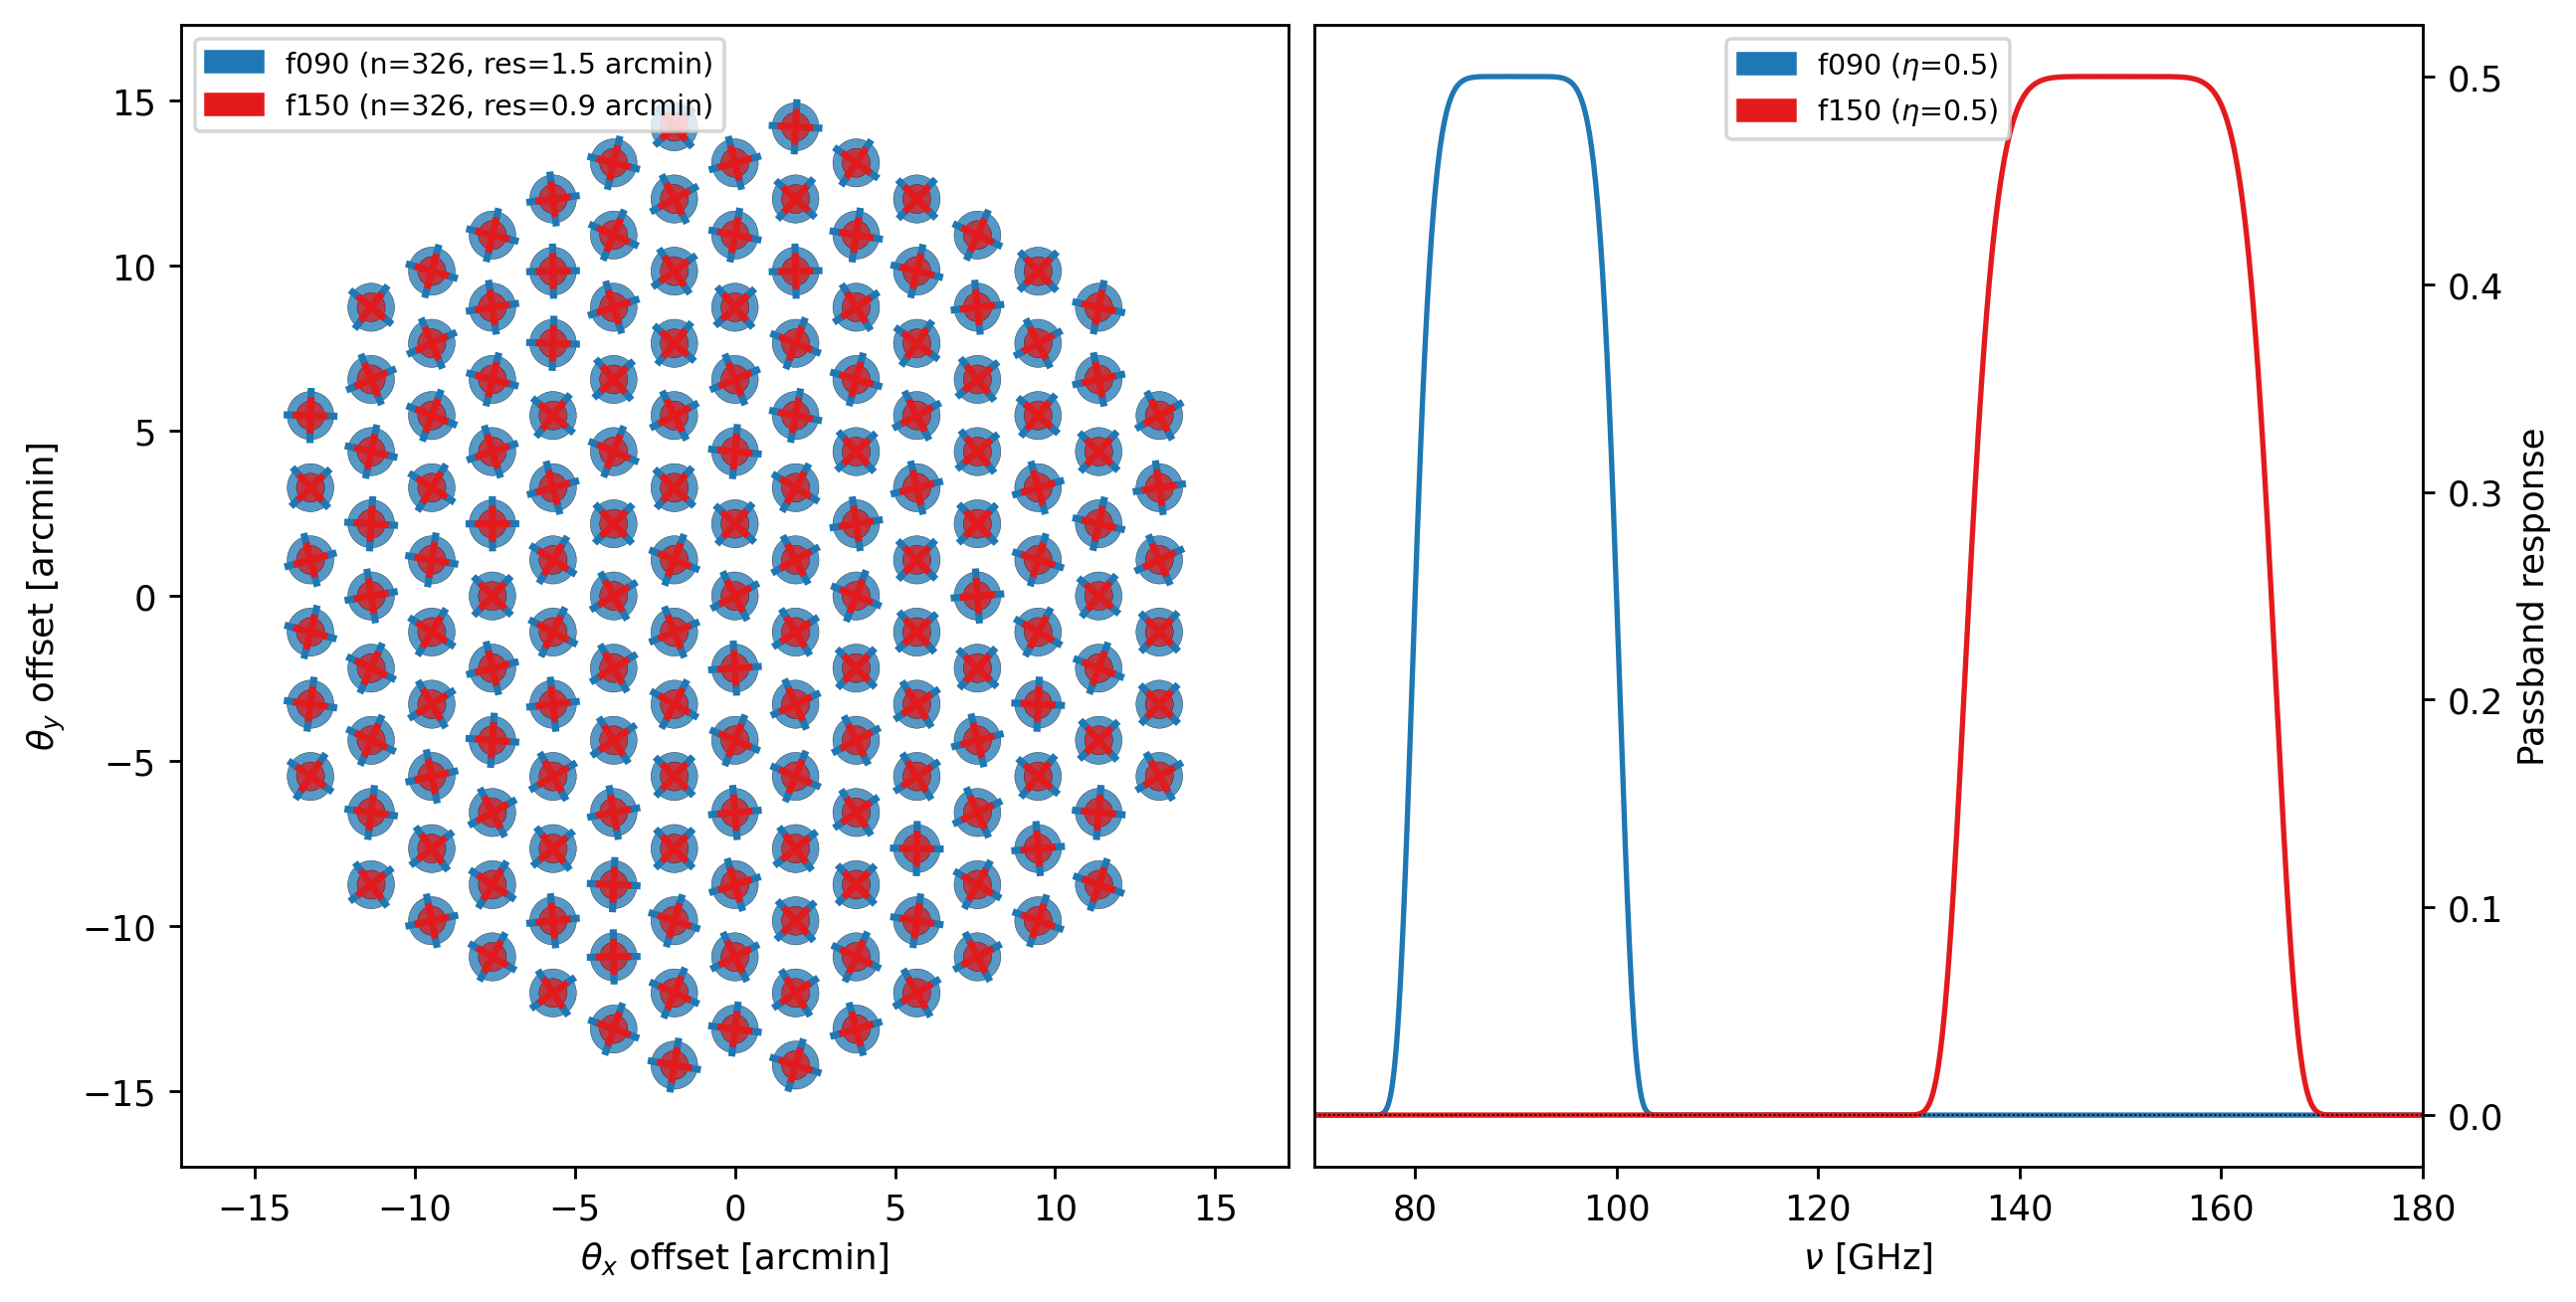

In [2]:
print(instrument)
instrument.plot()

Let's observe the use the Einstein map, which has a faint polarization signature underneath the unpolarized signal of Einstein's face. Remember that all maps are five dimensional (stokes, frequency, time, y, x); this map has four channels in the stokes dimensions (the I, Q, U, and V [Stokes parameters](https://en.wikipedia.org/wiki/Stokes_parameters)). We can plot all the channels by giving ``plot`` a shaped set of stokes parameters.

2025-09-30 20:06:40.308 INFO: Fetching https://github.com/thomaswmorris/maria-data/raw/master/maps/einstein.h5


Downloading:   0%|                | 0.00/931k [00:00<?, ?B/s]

Downloading: 100%|████████████████| 931k/931k [00:00<00:00, 45.2MB/s]

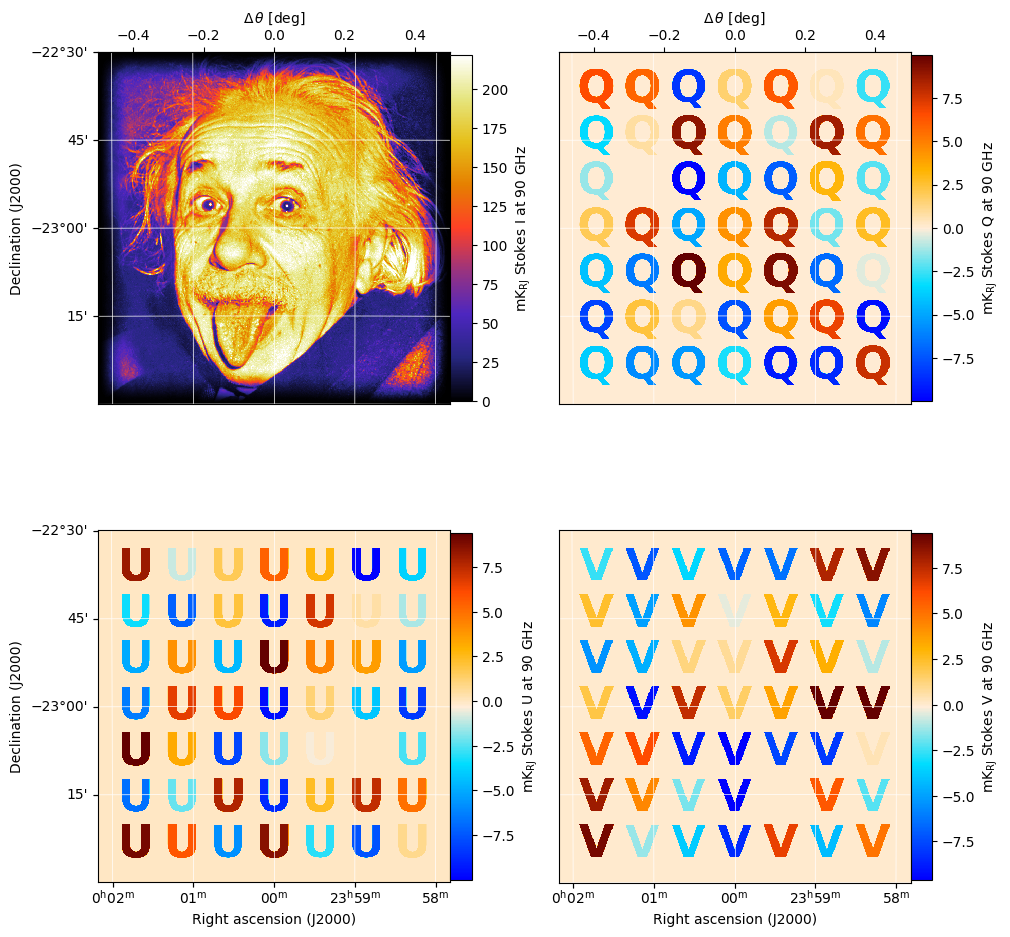

In [3]:
from maria.io import fetch

input_map = maria.map.load(fetch("maps/einstein.h5"))
input_map.plot(stokes=[["I", "Q"], 
                       ["U", "V"]])

PlanList(2 plans, 900 s):
                           start_time duration   target(ra,dec)     center(az,el)
chunk                                                                            
0      2025-10-01 01:41:43.849 +00:00    600 s  (0.3496’, -23°)  (95.92°, 61.18°)
1      2025-10-01 01:52:21.349 +00:00    300 s   (2.479’, -23°)  (95.47°, 63.02°)


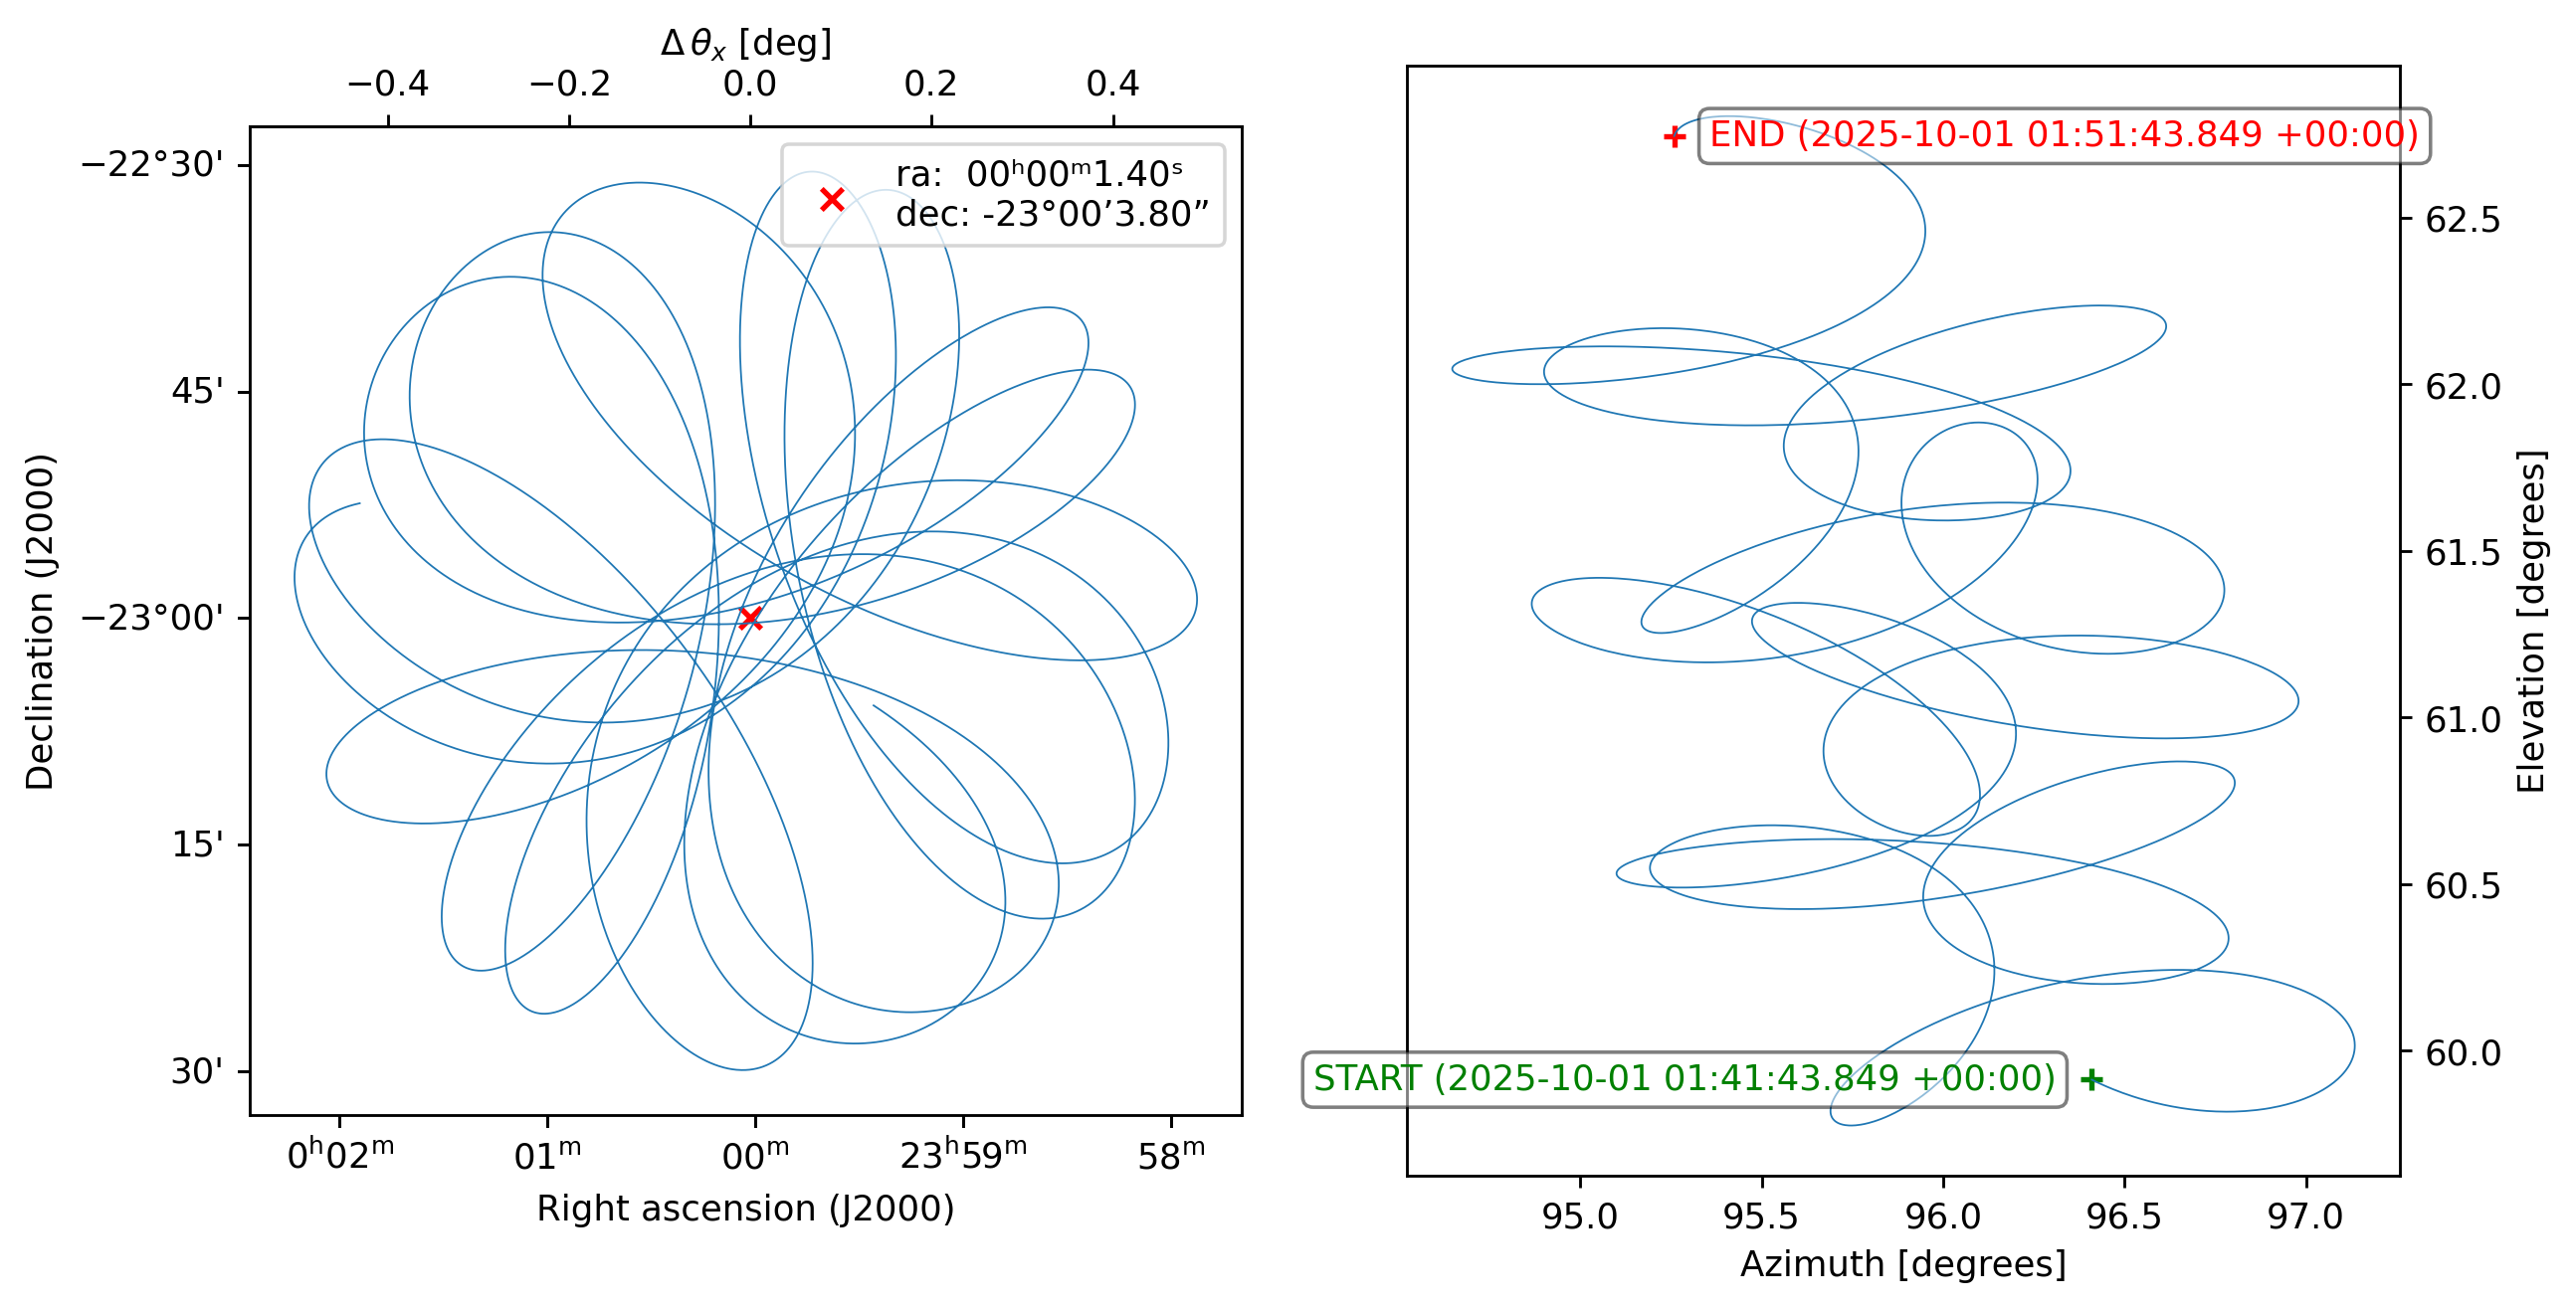

In [4]:
from maria import Planner

planner = Planner(target=input_map, site="llano_de_chajnantor", constraints={"el": (60, 90)})
plans = planner.generate_plans(total_duration=900,  # in seconds
                               sample_rate=50)  # in Hz

plans[0].plot()
print(plans)

In [5]:
sim = maria.Simulation(
    instrument,
    plans=plans,
    site="llano_de_chajnantor",
    atmosphere="2d",
    atmosphere_kwargs={"weather": {"pwv": 0.5}},
    map=input_map
)

print(sim)

Simulation
├ Instrument(1 array)
│ ├ arrays:
│ │            n     FOV baseline        bands polarized
│ │  array1  652  0.478°      0 m  [f090,f150]      True
│ │ 
│ └ bands:
│       name   center   width    η         NEP      NET_RJ         NET_CMB     FWHM
│    0  f090   90 GHz  20 GHz  0.5  5.445 aW√s  40 uK_RJ√s  49.13 uK_CMB√s   1.458’
│    1  f150  150 GHz  30 GHz  0.5  12.25 aW√s  60 uK_RJ√s    104 uK_CMB√s  0.8748’
├ Site:
│   region: chajnantor
│   timezone: America/Santiago
│   location:
│     longitude: 67°45’17.28” W
│     latitude:  23°01’45.84” S
│     altitude: 5064 m
│   seasonal: True
│   diurnal: True
├ PlanList(2 plans, 900 s):
│                            start_time duration   target(ra,dec)     center(az,el)
│ chunk                                                                            
│ 0      2025-10-01 01:41:43.849 +00:00    600 s  (0.3496’, -23°)  (95.92°, 61.18°)
│ 1      2025-10-01 01:52:21.349 +00:00    300 s   (2.479’, -23°)  (95.47°, 63.02°)
├ '2d'
└ 

2025-09-30 20:06:53.627 INFO: Simulating observation 1 of 2


Constructing atmosphere:   0%|                | 0/10 [00:00<?, ?it/s]

Constructing atmosphere:  10%|█▌              | 1/10 [00:02<00:18,  2.07s/it]

Constructing atmosphere:  20%|███▏            | 2/10 [00:03<00:15,  1.98s/it]

Constructing atmosphere:  30%|████▊           | 3/10 [00:06<00:14,  2.01s/it]

Constructing atmosphere:  40%|██████▍         | 4/10 [00:08<00:12,  2.04s/it]

Constructing atmosphere:  50%|████████        | 5/10 [00:10<00:10,  2.08s/it]

Constructing atmosphere:  60%|█████████▌      | 6/10 [00:12<00:08,  2.05s/it]

Constructing atmosphere:  70%|███████████▏    | 7/10 [00:14<00:06,  2.18s/it]

Constructing atmosphere:  80%|████████████▊   | 8/10 [00:16<00:04,  2.18s/it]

Constructing atmosphere:  90%|██████████████▍ | 9/10 [00:18<00:02,  2.14s/it]

Constructing atmosphere: 100%|████████████████| 10/10 [00:21<00:00,  2.12s/it]

Constructing atmosphere: 100%|████████████████| 10/10 [00:21<00:00,  2.10s/it]

Generating turbulence:   0%|                | 0/10 [00:00<?, ?it/s]

Generating turbulence:  30%|████▊           | 3/10 [00:00<00:00, 27.62it/s]

Generating turbulence:  60%|█████████▌      | 6/10 [00:00<00:00, 21.29it/s]

Generating turbulence:  90%|██████████████▍ | 9/10 [00:00<00:00, 16.79it/s]

Generating turbulence: 100%|████████████████| 10/10 [00:00<00:00, 17.00it/s]

Sampling turbulence:   0%|                | 0/10 [00:00<?, ?it/s]

Sampling turbulence:  10%|█▌              | 1/10 [00:01<00:14,  1.56s/it]

Sampling turbulence:  20%|███▏            | 2/10 [00:02<00:09,  1.15s/it]

Sampling turbulence:  30%|████▊           | 3/10 [00:03<00:07,  1.03s/it]

Sampling turbulence:  40%|██████▍         | 4/10 [00:04<00:05,  1.01it/s]

Sampling turbulence:  50%|████████        | 5/10 [00:05<00:04,  1.04it/s]

Sampling turbulence:  60%|█████████▌      | 6/10 [00:06<00:03,  1.05it/s]

Sampling turbulence:  70%|███████████▏    | 7/10 [00:06<00:02,  1.07it/s]

Sampling turbulence:  80%|████████████▊   | 8/10 [00:07<00:01,  1.08it/s]

Sampling turbulence:  90%|██████████████▍ | 9/10 [00:08<00:00,  1.07it/s]

Sampling turbulence: 100%|████████████████| 10/10 [00:09<00:00,  1.09it/s]

Sampling turbulence: 100%|████████████████| 10/10 [00:09<00:00,  1.03it/s]

Computing atmospheric emission:   0%|                | 0/2 [00:00<?, ?it/s]

Computing atmospheric emission:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]

Computing atmospheric emission:  50%|████████        | 1/2 [00:01<00:01,  1.79s/it, band=f090]

Computing atmospheric emission:  50%|████████        | 1/2 [00:01<00:01,  1.79s/it, band=f150]

Computing atmospheric emission: 100%|████████████████| 2/2 [00:02<00:00,  1.02s/it, band=f150]

Computing atmospheric emission: 100%|████████████████| 2/2 [00:02<00:00,  1.13s/it, band=f150]

Sampling map:   0%|                | 0/2 [00:00<?, ?it/s, band=, channel=, stokes=]

Sampling map:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]               

Sampling map:   0%|                | 0/2 [00:05<?, ?it/s, band=f090, channel=(0 Hz, inf Hz), stokes=I]

Sampling map:   0%|                | 0/2 [00:05<?, ?it/s, band=f090, channel=(0 Hz, inf Hz), stokes=Q]

Sampling map:   0%|                | 0/2 [00:05<?, ?it/s, band=f090, channel=(0 Hz, inf Hz), stokes=U]

Sampling map:   0%|                | 0/2 [00:05<?, ?it/s, band=f090, channel=(0 Hz, inf Hz), stokes=V]

Sampling map:  50%|████████        | 1/2 [00:05<00:05,  5.45s/it, band=f090, channel=(0 Hz, inf Hz), stokes=V]

Sampling map:  50%|████████        | 1/2 [00:05<00:05,  5.45s/it, band=f150]                                  

Sampling map:  50%|████████        | 1/2 [00:09<00:05,  5.45s/it, band=f150, channel=(0 Hz, inf Hz), stokes=I]

Sampling map:  50%|████████        | 1/2 [00:09<00:05,  5.45s/it, band=f150, channel=(0 Hz, inf Hz), stokes=Q]

Sampling map:  50%|████████        | 1/2 [00:09<00:05,  5.45s/it, band=f150, channel=(0 Hz, inf Hz), stokes=U]

Sampling map:  50%|████████        | 1/2 [00:09<00:05,  5.45s/it, band=f150, channel=(0 Hz, inf Hz), stokes=V]

Sampling map: 100%|████████████████| 2/2 [00:09<00:00,  4.71s/it, band=f150, channel=(0 Hz, inf Hz), stokes=V]

Sampling map: 100%|████████████████| 2/2 [00:09<00:00,  4.82s/it, band=f150, channel=(0 Hz, inf Hz), stokes=V]

Generating noise:   0%|                | 0/2 [00:00<?, ?it/s]

Generating noise:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]

Generating noise:  50%|████████        | 1/2 [00:00<00:00,  1.58it/s, band=f090]

Generating noise:  50%|████████        | 1/2 [00:00<00:00,  1.58it/s, band=f150]

Generating noise: 100%|████████████████| 2/2 [00:00<00:00,  2.22it/s, band=f150]

Generating noise: 100%|████████████████| 2/2 [00:00<00:00,  2.09it/s, band=f150]

2025-09-30 20:07:53.098 INFO: Simulated observation 1 of 2 in 59.46 s


2025-09-30 20:07:53.099 INFO: Simulating observation 2 of 2


Constructing atmosphere:   0%|                | 0/10 [00:00<?, ?it/s]

Constructing atmosphere:  10%|█▌              | 1/10 [00:00<00:07,  1.25it/s]

Constructing atmosphere:  20%|███▏            | 2/10 [00:01<00:06,  1.25it/s]

Constructing atmosphere:  30%|████▊           | 3/10 [00:02<00:05,  1.28it/s]

Constructing atmosphere:  40%|██████▍         | 4/10 [00:03<00:04,  1.27it/s]

Constructing atmosphere:  50%|████████        | 5/10 [00:03<00:03,  1.27it/s]

Constructing atmosphere:  60%|█████████▌      | 6/10 [00:04<00:03,  1.28it/s]

Constructing atmosphere:  70%|███████████▏    | 7/10 [00:05<00:02,  1.23it/s]

Constructing atmosphere:  80%|████████████▊   | 8/10 [00:06<00:01,  1.21it/s]

Constructing atmosphere:  90%|██████████████▍ | 9/10 [00:07<00:00,  1.20it/s]

Constructing atmosphere: 100%|████████████████| 10/10 [00:08<00:00,  1.21it/s]

Constructing atmosphere: 100%|████████████████| 10/10 [00:08<00:00,  1.23it/s]

Generating turbulence:   0%|                | 0/10 [00:00<?, ?it/s]

Generating turbulence:  40%|██████▍         | 4/10 [00:00<00:00, 38.45it/s]

Generating turbulence:  80%|████████████▊   | 8/10 [00:00<00:00, 29.98it/s]

Generating turbulence: 100%|████████████████| 10/10 [00:00<00:00, 28.08it/s]

Sampling turbulence:   0%|                | 0/10 [00:00<?, ?it/s]

Sampling turbulence:  10%|█▌              | 1/10 [00:01<00:11,  1.24s/it]

Sampling turbulence:  20%|███▏            | 2/10 [00:01<00:06,  1.22it/s]

Sampling turbulence:  30%|████▊           | 3/10 [00:02<00:04,  1.42it/s]

Sampling turbulence:  40%|██████▍         | 4/10 [00:02<00:03,  1.57it/s]

Sampling turbulence:  50%|████████        | 5/10 [00:03<00:03,  1.65it/s]

Sampling turbulence:  60%|█████████▌      | 6/10 [00:03<00:02,  1.71it/s]

Sampling turbulence:  70%|███████████▏    | 7/10 [00:04<00:01,  1.74it/s]

Sampling turbulence:  80%|████████████▊   | 8/10 [00:05<00:01,  1.75it/s]

Sampling turbulence:  90%|██████████████▍ | 9/10 [00:05<00:00,  1.76it/s]

Sampling turbulence: 100%|████████████████| 10/10 [00:06<00:00,  1.77it/s]

Sampling turbulence: 100%|████████████████| 10/10 [00:06<00:00,  1.60it/s]

Computing atmospheric emission:   0%|                | 0/2 [00:00<?, ?it/s]

Computing atmospheric emission:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]

Computing atmospheric emission:  50%|████████        | 1/2 [00:01<00:01,  1.42s/it, band=f090]

Computing atmospheric emission:  50%|████████        | 1/2 [00:01<00:01,  1.42s/it, band=f150]

Computing atmospheric emission: 100%|████████████████| 2/2 [00:01<00:00,  1.43it/s, band=f150]

Computing atmospheric emission: 100%|████████████████| 2/2 [00:01<00:00,  1.24it/s, band=f150]

Sampling map:   0%|                | 0/2 [00:00<?, ?it/s, band=, channel=, stokes=]

Sampling map:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]               

Sampling map:   0%|                | 0/2 [00:03<?, ?it/s, band=f090, channel=(0 Hz, inf Hz), stokes=I]

Sampling map:   0%|                | 0/2 [00:03<?, ?it/s, band=f090, channel=(0 Hz, inf Hz), stokes=Q]

Sampling map:   0%|                | 0/2 [00:03<?, ?it/s, band=f090, channel=(0 Hz, inf Hz), stokes=U]

Sampling map:   0%|                | 0/2 [00:03<?, ?it/s, band=f090, channel=(0 Hz, inf Hz), stokes=V]

Sampling map:  50%|████████        | 1/2 [00:03<00:03,  3.49s/it, band=f090, channel=(0 Hz, inf Hz), stokes=V]

Sampling map:  50%|████████        | 1/2 [00:03<00:03,  3.49s/it, band=f150]                                  

Sampling map:  50%|████████        | 1/2 [00:05<00:03,  3.49s/it, band=f150, channel=(0 Hz, inf Hz), stokes=I]

Sampling map:  50%|████████        | 1/2 [00:05<00:03,  3.49s/it, band=f150, channel=(0 Hz, inf Hz), stokes=Q]

Sampling map:  50%|████████        | 1/2 [00:05<00:03,  3.49s/it, band=f150, channel=(0 Hz, inf Hz), stokes=U]

Sampling map:  50%|████████        | 1/2 [00:05<00:03,  3.49s/it, band=f150, channel=(0 Hz, inf Hz), stokes=V]

Sampling map: 100%|████████████████| 2/2 [00:05<00:00,  2.55s/it, band=f150, channel=(0 Hz, inf Hz), stokes=V]

Sampling map: 100%|████████████████| 2/2 [00:05<00:00,  2.69s/it, band=f150, channel=(0 Hz, inf Hz), stokes=V]

Generating noise:   0%|                | 0/2 [00:00<?, ?it/s]

Generating noise:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]

Generating noise:  50%|████████        | 1/2 [00:00<00:00,  2.23it/s, band=f090]

Generating noise:  50%|████████        | 1/2 [00:00<00:00,  2.23it/s, band=f150]

Generating noise: 100%|████████████████| 2/2 [00:00<00:00,  3.71it/s, band=f150]

Generating noise: 100%|████████████████| 2/2 [00:00<00:00,  3.37it/s, band=f150]

2025-09-30 20:08:23.053 INFO: Simulated observation 2 of 2 in 29.94 s


[TOD(shape=(652, 30000), fields=['atmosphere', 'map', 'noise'], units='K_RJ', start=2025-10-01 01:51:43.829 +00:00, duration=600.0s, sample_rate=50.0Hz, metadata={'atmosphere': True, 'sim_time': <Arrow [2025-09-30T20:07:40.410920+00:00]>, 'altitude': 5064.0, 'region': 'chajnantor', 'pwv': 0.5, 'base_temperature': 273.714}), TOD(shape=(652, 15000), fields=['atmosphere', 'map', 'noise'], units='K_RJ', start=2025-10-01 01:57:21.329 +00:00, duration=300.0s, sample_rate=50.0Hz, metadata={'atmosphere': True, 'sim_time': <Arrow [2025-09-30T20:08:17.236773+00:00]>, 'altitude': 5064.0, 'region': 'chajnantor', 'pwv': 1.156, 'base_temperature': 273.682})]


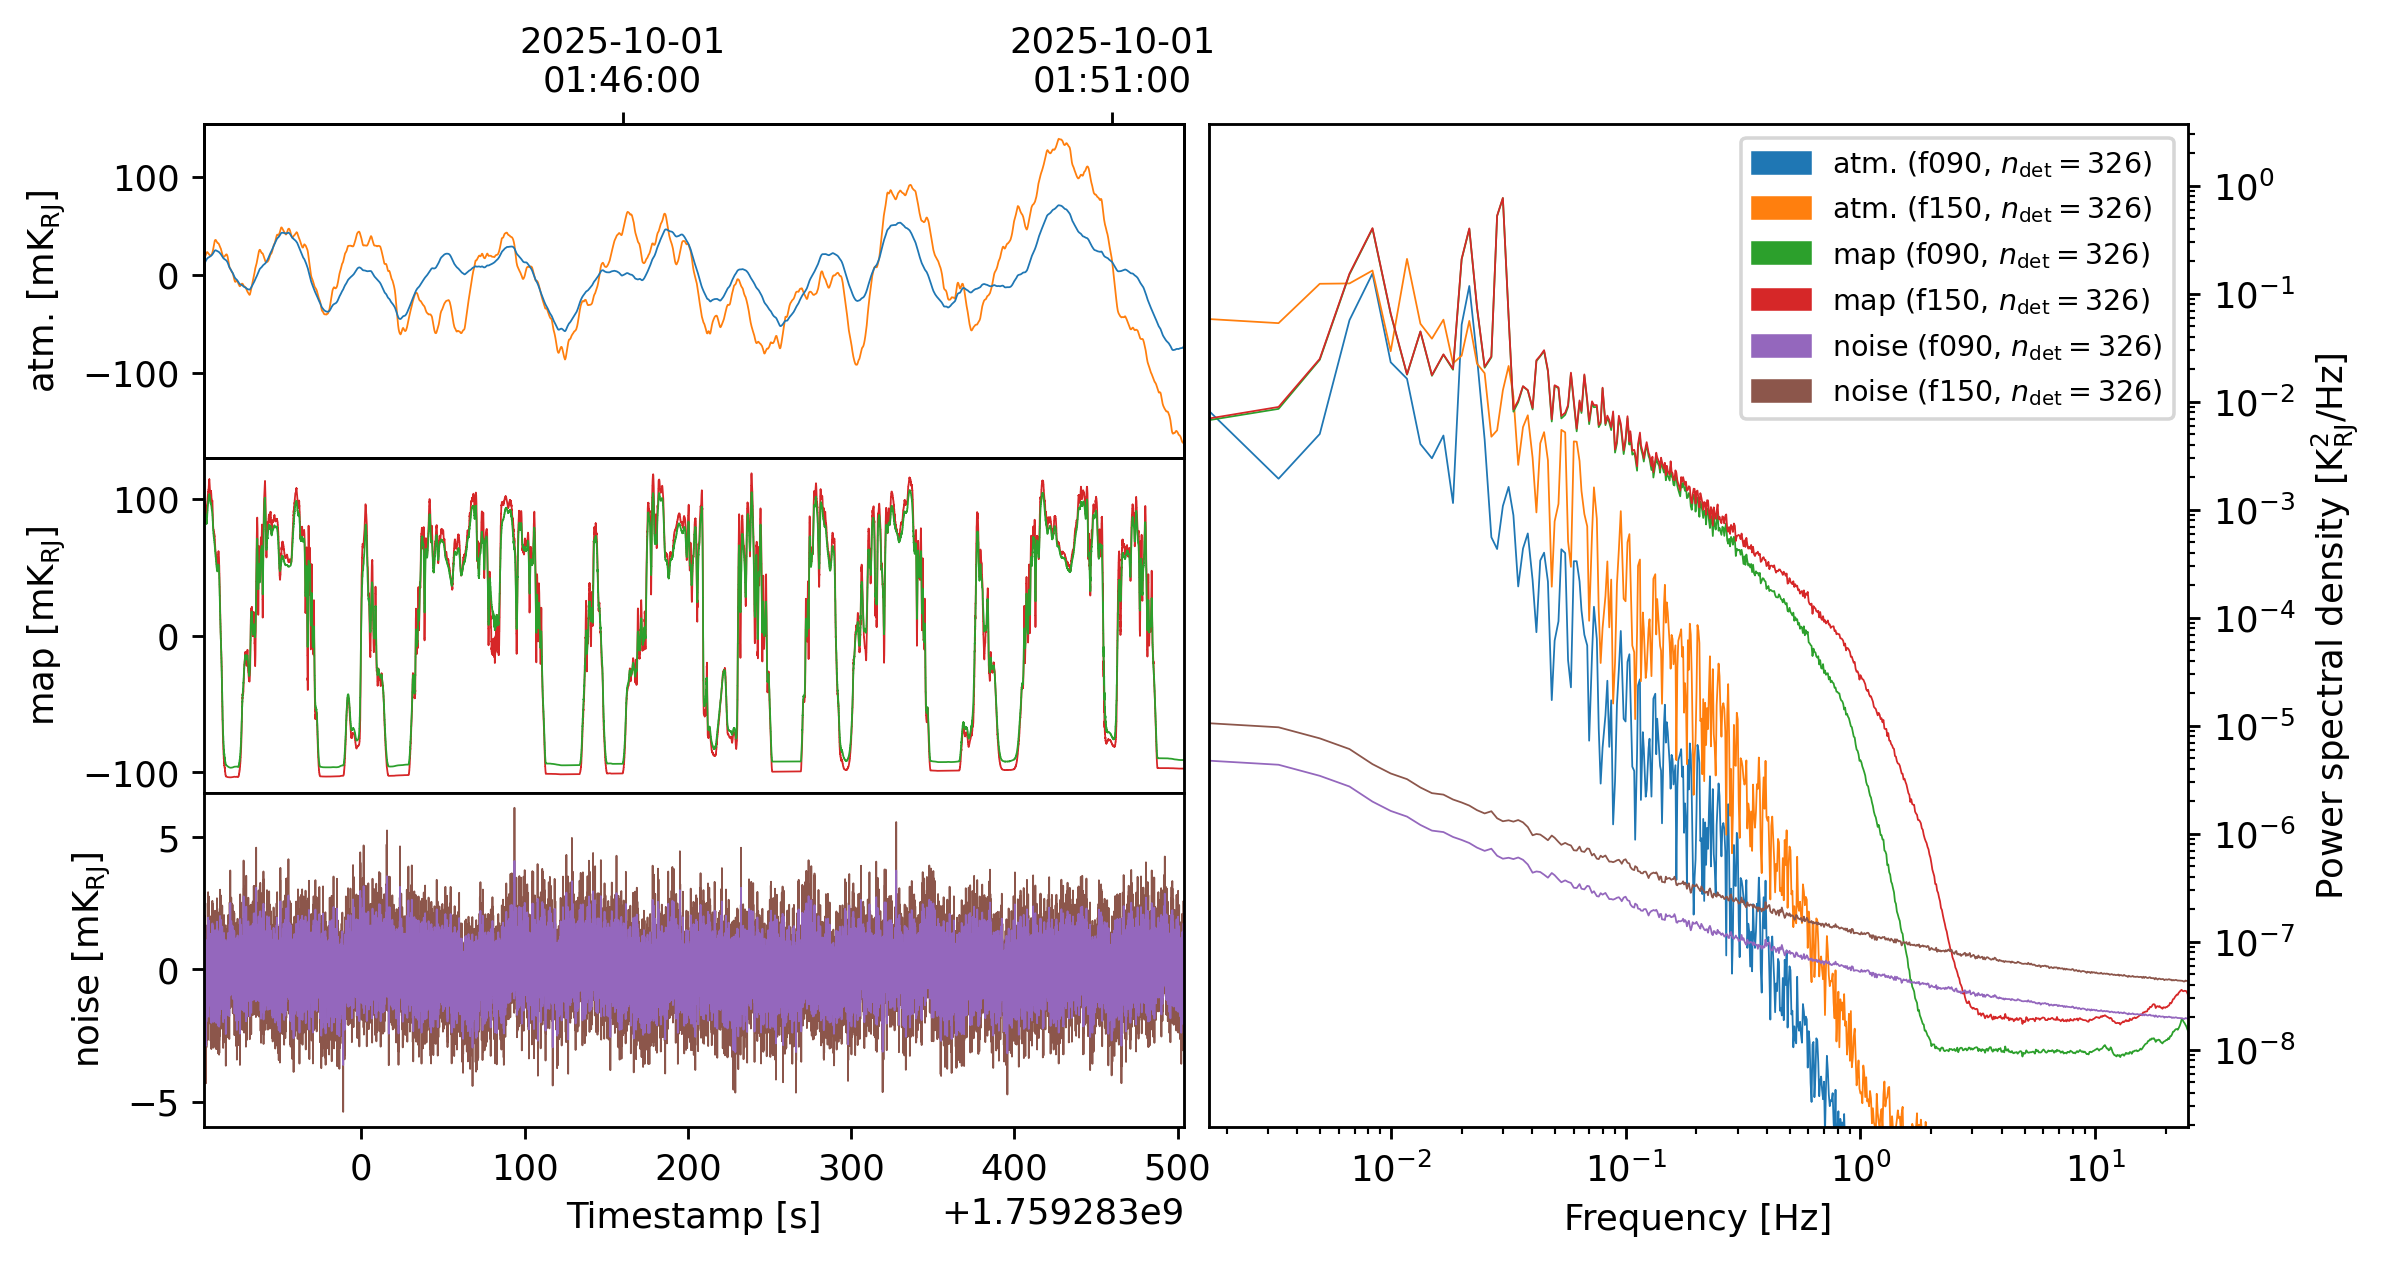

In [6]:
tods = sim.run()

print(tods)
tods[0].plot()

In [7]:
tods

[TOD(shape=(652, 30000), fields=['atmosphere', 'map', 'noise'], units='K_RJ', start=2025-10-01 01:51:43.829 +00:00, duration=600.0s, sample_rate=50.0Hz, metadata={'atmosphere': True, 'sim_time': <Arrow [2025-09-30T20:07:40.410920+00:00]>, 'altitude': 5064.0, 'region': 'chajnantor', 'pwv': 0.5, 'base_temperature': 273.714}),
 TOD(shape=(652, 15000), fields=['atmosphere', 'map', 'noise'], units='K_RJ', start=2025-10-01 01:57:21.329 +00:00, duration=300.0s, sample_rate=50.0Hz, metadata={'atmosphere': True, 'sim_time': <Arrow [2025-09-30T20:08:17.236773+00:00]>, 'altitude': 5064.0, 'region': 'chajnantor', 'pwv': 1.156, 'base_temperature': 273.682})]

In [8]:
from maria.mappers import BinMapper

mapper = BinMapper(
    center=(0, -23),
    stokes="IQU",
    frame="ra/dec",
    width=1.0,
    height=1.0,
    resolution=1.0 / 256,
    tod_preprocessing={
        "window": {"name": "tukey", "kwargs": {"alpha": 0.1}},
        "remove_spline": {"knot_spacing": 60, "remove_el_gradient": True},
        "remove_modes": {"modes_to_remove": [0]},
    },
    map_postprocessing={
        "gaussian_filter": {"sigma": 1},
        # "median_filter": {"size": 1},
    },
    units="mK_RJ",
)

mapper.add_tods(tods)

output_map = mapper.run()

print(output_map)

Mapping band f090:   0%|          | 0/2 [00:00<?, ?it/s, stokes=I, tod=1/2]

Mapping band f090:   0%|          | 0/2 [00:03<?, ?it/s, stokes=I, tod=1/2]

Mapping band f090:   0%|          | 0/2 [00:03<?, ?it/s, stokes=Q, tod=1/2]

Mapping band f090:   0%|          | 0/2 [00:03<?, ?it/s, stokes=U, tod=1/2]

Mapping band f090:  50%|█████     | 1/2 [00:03<00:03,  3.56s/it, stokes=U, tod=1/2]

Mapping band f090:  50%|█████     | 1/2 [00:05<00:03,  3.56s/it, stokes=I, tod=2/2]

Mapping band f090:  50%|█████     | 1/2 [00:05<00:03,  3.56s/it, stokes=Q, tod=2/2]

Mapping band f090:  50%|█████     | 1/2 [00:05<00:03,  3.56s/it, stokes=U, tod=2/2]

Mapping band f090: 100%|██████████| 2/2 [00:05<00:00,  2.69s/it, stokes=U, tod=2/2]

Mapping band f090: 100%|██████████| 2/2 [00:05<00:00,  2.82s/it, stokes=U, tod=2/2]


2025-09-30 20:08:36.462 INFO: Ran mapper for band f090 in 5.641 s.


Mapping band f150:   0%|          | 0/2 [00:00<?, ?it/s, stokes=I, tod=1/2]

Mapping band f150:   0%|          | 0/2 [00:03<?, ?it/s, stokes=I, tod=1/2]

Mapping band f150:   0%|          | 0/2 [00:03<?, ?it/s, stokes=Q, tod=1/2]

Mapping band f150:   0%|          | 0/2 [00:03<?, ?it/s, stokes=U, tod=1/2]

Mapping band f150:  50%|█████     | 1/2 [00:03<00:03,  3.51s/it, stokes=U, tod=1/2]

Mapping band f150:  50%|█████     | 1/2 [00:05<00:03,  3.51s/it, stokes=I, tod=2/2]

Mapping band f150:  50%|█████     | 1/2 [00:05<00:03,  3.51s/it, stokes=Q, tod=2/2]

Mapping band f150:  50%|█████     | 1/2 [00:05<00:03,  3.51s/it, stokes=U, tod=2/2]

Mapping band f150: 100%|██████████| 2/2 [00:05<00:00,  2.65s/it, stokes=U, tod=2/2]

Mapping band f150: 100%|██████████| 2/2 [00:05<00:00,  2.78s/it, stokes=U, tod=2/2]


2025-09-30 20:08:42.033 INFO: Ran mapper for band f150 in 5.558 s.


ProjectedMap:
  shape(stokes, nu, y, x): (3, 2, 256, 256)
  stokes: IQU
  nu: [ 90. 150.] GHz
  t: naive
  z: naive
  quantity: rayleigh_jeans_temperature
  units: mK_RJ
    min: -2.528e+02
    max: 2.116e+02
  center:
    ra:  00ʰ00ᵐ0.00ˢ
    dec: -23°00’0.00”
  size(y, x): (1°, 1°)
  resolution(y, x): (14.06”, 14.06”)
  beam(maj, min, rot): [[1.45801568 1.45801568 0.        ]
 [0.87480941 0.87480941 0.        ]]’
  memory: 6.291 MB


Note that we can't see any of the circular polarization, since our instrument isn't sensitive to it.

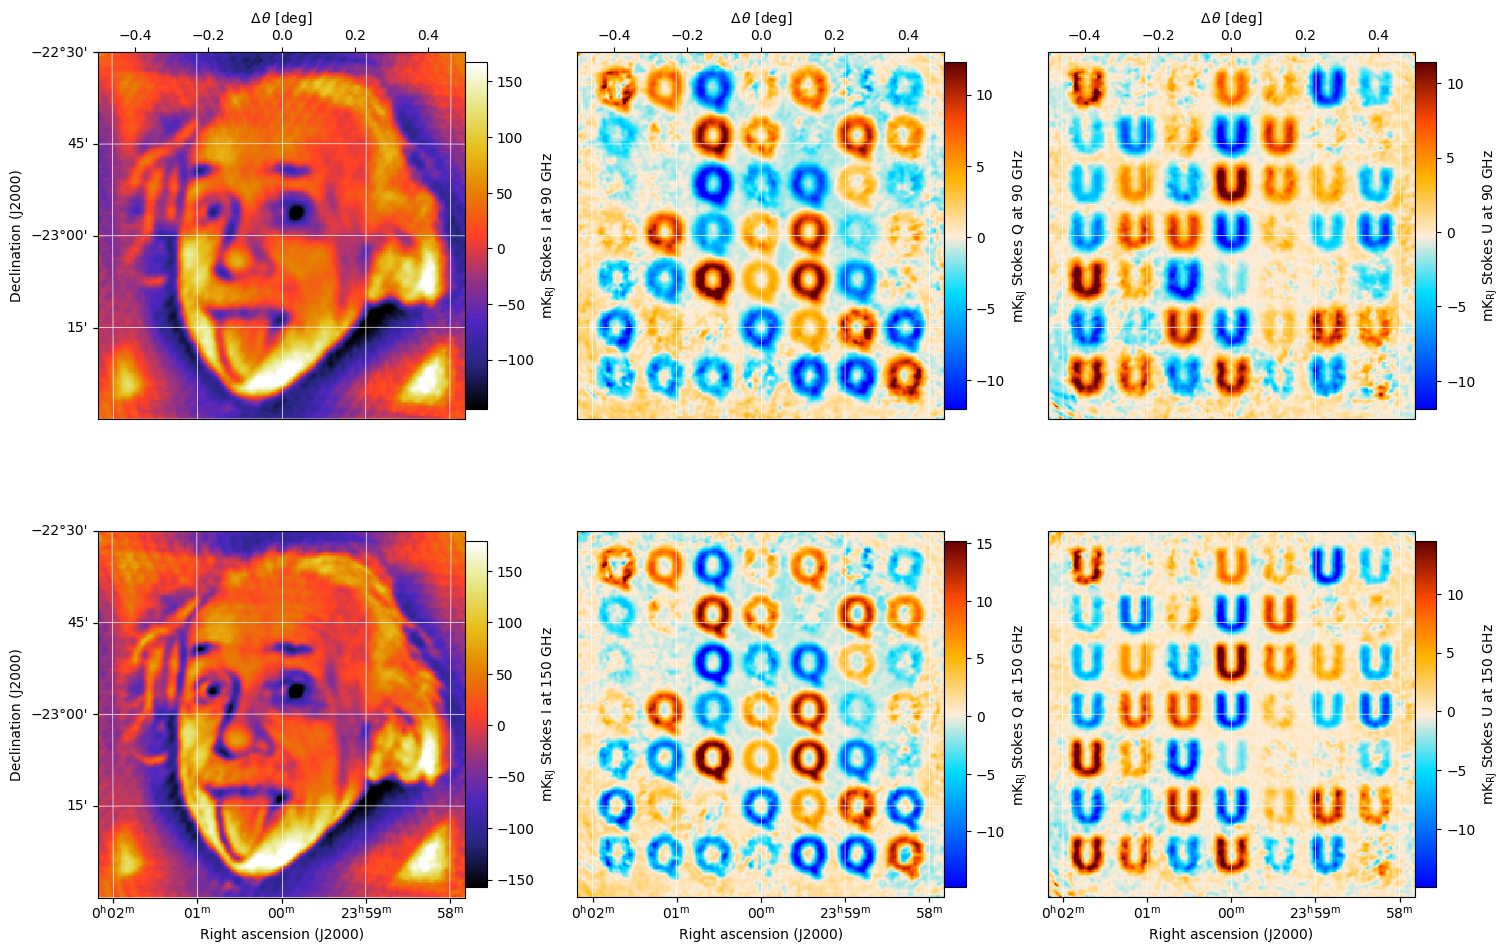

In [9]:
output_map.plot(stokes=["I", "Q", "U"], nu_index=[[0], [1]])